In [1]:
import numpy as np
from numpy import loadtxt
import fitsio
import healpy as hp
import healsparse as hsp
import skyproj
import matplotlib.pyplot as plt
import Config
from os import listdir
import fitsio
import treecorr

In [2]:
n = [9, 2, 4, 6, 5]
p = [0.55, 0.25, 0.25, 0.67, 0.8]
s = 100 # Don't need to include size later on, will just be doing 1 draw.
test = np.random.binomial(n, p, size = (s, 5))

In [3]:
dataFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/Verification/OneBinMock.fits'

data = fitsio.read(dataFile)

PIX = data['PIX']
T_S = data['T_S'].astype(int)
O_G = data['O_G'].astype(int)
P_OS_TS = data['P_OS_TS']
P_CS_OS = data['P_CS_OS']
P_CG_OG = data['P_CG_OG']

In [35]:
mock_OS = np.random.binomial(T_S, P_OS_TS, size = (1, len(T_S)))

mock_CS = []
for i in range(len(mock_OS)):
    mock_CS.append(np.random.binomial(mock_OS[i], P_CS_OS) + np.random.binomial(O_G, (1-P_CG_OG)))
    
mock_CG = []
for i in range(len(mock_OS)):
    mock_CG.append(np.random.binomial(O_G, P_CG_OG) + np.random.binomial(mock_OS[i], (1-P_CS_OS)))

recovered_OS = []
for i in range(len(mock_OS)):
    recovered_OS_ind = ((P_CG_OG * mock_CS[i]) + ((P_CG_OG - 1) * mock_CG[i])) / (P_CS_OS + P_CG_OG - 1)
    recovered_OS_ind[np.where(recovered_OS_ind < 0)[0]] = 0
    recovered_OS_ind[np.where(recovered_OS_ind > (mock_CS[i] + mock_CG[i]))[0]] = mock_CS[i][np.where(recovered_OS_ind > (mock_CS[i] + mock_CG[i]))[0]] + mock_CG[i][np.where(recovered_OS_ind > (mock_CS[i] + mock_CG[i]))[0]]
    recovered_OS.append(recovered_OS_ind)
    
recovered_TS = []
for i in range(len(mock_OS)):
    recovered_TS.append(recovered_OS[i] / P_OS_TS)
recovered_TS = np.array(recovered_TS)

In [36]:
recovered_TS = np.median(recovered_TS, axis = 0)

In [37]:
full_original = np.full(12*(512**2), hp.UNSEEN)
full_original[PIX] = T_S

full_recovered = np.full(12*(512**2), hp.UNSEEN)
full_recovered[PIX] = recovered_TS

In [38]:
nside_coverage = 32
hspOrig = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=full_original)
hspReco = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=full_recovered)

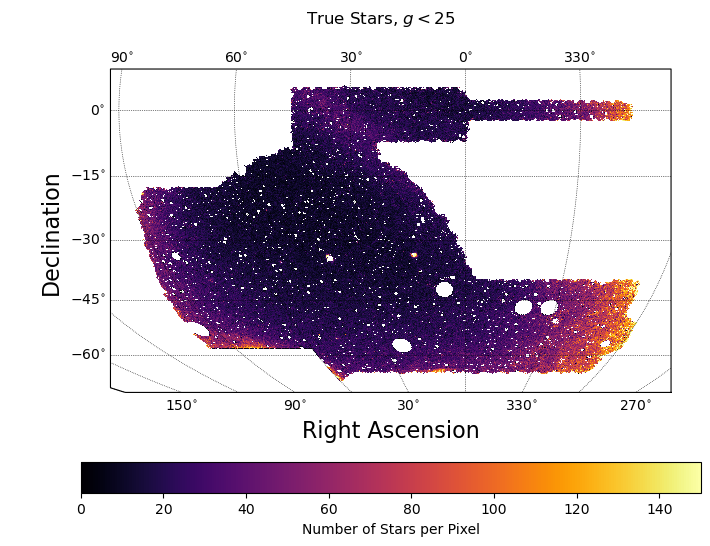

In [39]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspOrig, cmap = 'inferno')
plt.clim(0, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle(r'True Stars, $g<25$')
plt.show()

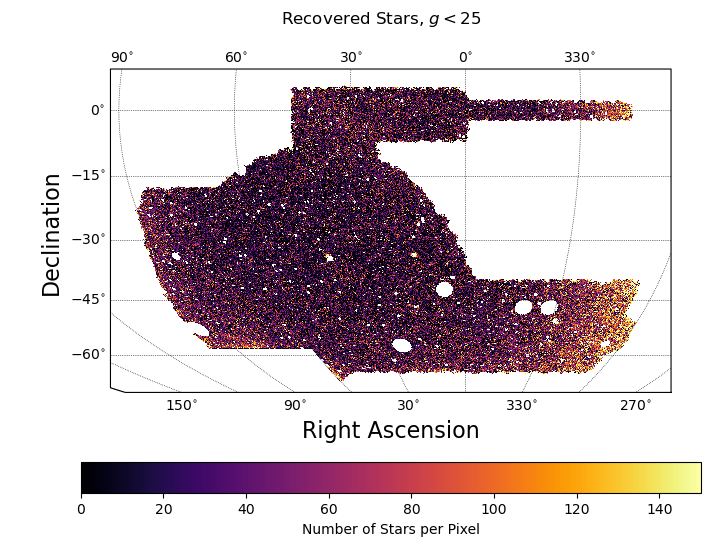

In [40]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspReco, cmap = 'inferno')
plt.clim(0, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle(r'Recovered Stars, $g<25$')
plt.show()

In [41]:
diff = np.full(12*(512**2), hp.UNSEEN)
diff[PIX] = T_S - recovered_TS

In [42]:
hspDiff = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=diff)

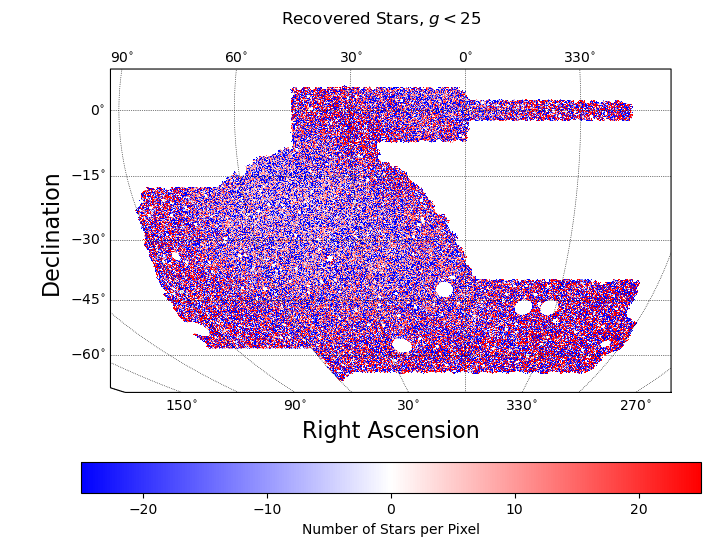

In [43]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspDiff, cmap = 'bwr')
plt.clim(-25, 25)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle(r'Recovered Stars, $g<25$')
plt.show()

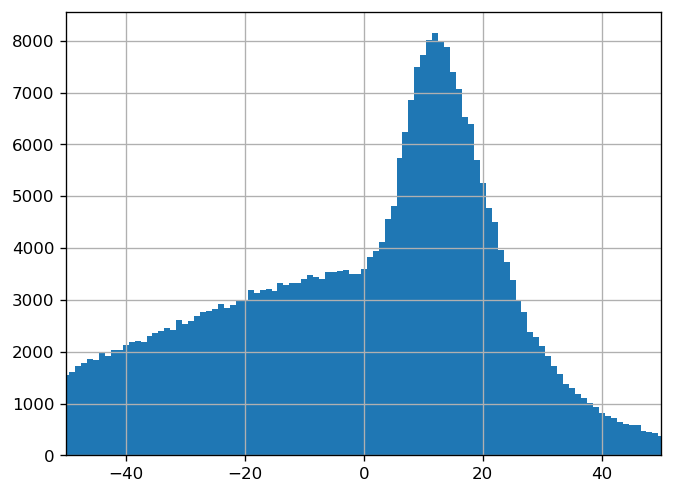

In [44]:
plt.figure(dpi = 120)
weight1 = plt.hist(diff[PIX], bins = np.linspace(-51.5, 51.5, 104))
plt.xlim([-50, 50])
plt.grid()
plt.show()

In [51]:
# from astropy.table import Table
# write_file = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/Verification/Mock_Map_Residuals.fits'

# my_table = Table()
# my_table['1'] = weight1[0]
# my_table['10'] = weight10[0]
# my_table['100'] = weight100[0]
# my_table['1000'] = weight1000[0]
# my_table.write(write_file, overwrite = True)

In [ ]:
np.average(diff[PIX])

In [ ]:
np.median(diff[PIX])

In [ ]:
ra, dec = hp.pixelfunc.pix2ang(512, PIX, nest = True, lonlat = True)

In [ ]:
min_sep = 0.4 * (np.pi / 180)
max_sep = 40 * (np.pi / 180)
nbins = 30

In [ ]:
ra = ra * np.pi / 180
dec = dec * np.pi / 180

In [ ]:
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=T_S)
nn = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
nn.process(cat)

In [ ]:
randCat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=np.random.normal(loc = np.average(T_S), scale = np.std(T_S), size = len(T_S)))
rr = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
rr.process(randCat)

In [ ]:
xi,varxi = nn.calculateXi(rr=rr)

In [ ]:
ocat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=recovered_TS)
onn = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
onn.process(ocat)

In [ ]:
orandCat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=np.random.normal(loc = np.average(recovered_TS), scale = np.std(recovered_TS), size = len(recovered_TS)))
orr = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
orr.process(orandCat)

In [ ]:
oxi,ovarxi = onn.calculateXi(rr=orr)

In [ ]:
r = nn.rnom * 180 / np.pi

In [ ]:
plt.figure(dpi = 120)
plt.errorbar(r, xi, yerr = np.sqrt(varxi), marker = '.', label = 'Truth')
plt.errorbar(r, oxi, yerr = np.sqrt(ovarxi), marker = '.', label = 'Recovered')
plt.xlabel('Separation (Degrees)')
plt.xscale('log')
plt.ylabel('Xi * Sep')
plt.title('Two Point Correlations')
plt.legend()
plt.grid()
plt.show()